In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F
from PIL import Image
import json
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from scipy.stats import skew, kurtosis
import pandas as pd

# Dataset Configuration

In [2]:
# Konfigurasi path
DATA_DIR = "data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Konfigurasi preprocessing
IMG_SIZE = 256  # Resize ke 256x256
BATCH_SIZE = 32
NUM_WORKERS = 4

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Custom Dataset dengan Preprocessing

In [3]:
class BatikDataset(Dataset):    
    def __init__(self, data_dir, transform=None, use_clahe=True, use_denoising=True, use_edge_enhancement=True):
        self.data_dir = data_dir
        self.transform = transform
        self.use_clahe = use_clahe
        self.use_denoising = use_denoising
        self.use_edge_enhancement = use_edge_enhancement
        self.classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Load semua file paths dan labels
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))
        
        print(f"Loaded {len(self.samples)} images from {len(self.classes)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Baca gambar dengan OpenCV
        image = cv2.imread(img_path)
        
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")
        
        # 1. Resize ke ukuran seragam (256x256)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        
        # 2. Noise Reduction - Bilateral Filter (mempertahankan edge)
        if self.use_denoising:
            image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
        
        # 3. Konversi ke grayscale untuk tekstur
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 4. CLAHE untuk menstabilkan kontras
        if self.use_clahe:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray = clahe.apply(gray)
        
        # 5. Edge Enhancement - Unsharp Masking
        if self.use_edge_enhancement:
            # Gaussian blur
            gaussian = cv2.GaussianBlur(gray, (0, 0), 2.0)
            # Unsharp mask
            gray = cv2.addWeighted(gray, 1.5, gaussian, -0.5, 0)
        
        # 6. Normalisasi intensitas (0-255)
        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
        
        # Konversi kembali ke 3 channel untuk kompatibilitas dengan VGG16
        # (grayscale direplikasi ke 3 channel)
        image_processed = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        
        # Konversi ke PIL Image untuk transform
        image_pil = Image.fromarray(image_processed)
        
        # Apply transforms jika ada
        if self.transform:
            image_pil = self.transform(image_pil)
        
        return image_pil, label
    
    def get_class_names(self):
        return self.classes

# Data Transforms

In [4]:
# Transform untuk training (dengan augmentasi)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform untuk validation dan test (tanpa augmentasi)
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Datasets

In [5]:
# Load datasets dengan preprocessing yang ditingkatkan
print("Loading training data...")
train_dataset = BatikDataset(TRAIN_DIR, transform=train_transform, 
                            use_clahe=True, use_denoising=True, use_edge_enhancement=True)

print("\nLoading validation data...")
val_dataset = BatikDataset(VAL_DIR, transform=val_test_transform, 
                          use_clahe=True, use_denoising=True, use_edge_enhancement=True)

print("\nLoading test data...")
test_dataset = BatikDataset(TEST_DIR, transform=val_test_transform, 
                           use_clahe=True, use_denoising=True, use_edge_enhancement=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                         shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                       shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                        shuffle=False, num_workers=NUM_WORKERS)

# Print dataset info
print(f"\n{'='*50}")
print(f"Dataset Summary:")
print(f"{'='*50}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Preprocessing: Bilateral Filter + CLAHE + Edge Enhancement + Normalization")
print(f"{'='*50}")

Loading training data...
Loaded 101613 images from 111 classes

Loading validation data...
Loaded 30894 images from 111 classes

Loading test data...
Loaded 31039 images from 111 classes

Dataset Summary:
Number of classes: 111
Training samples: 101613
Validation samples: 30894
Test samples: 31039
Image size: 256x256
Batch size: 32
Preprocessing: Bilateral Filter + CLAHE + Edge Enhancement + Normalization
Loaded 30894 images from 111 classes

Loading test data...
Loaded 31039 images from 111 classes

Dataset Summary:
Number of classes: 111
Training samples: 101613
Validation samples: 30894
Test samples: 31039
Image size: 256x256
Batch size: 32
Preprocessing: Bilateral Filter + CLAHE + Edge Enhancement + Normalization


# Visualisasi Sample Data

Training samples with preprocessing (Grayscale + CLAHE + Normalization):


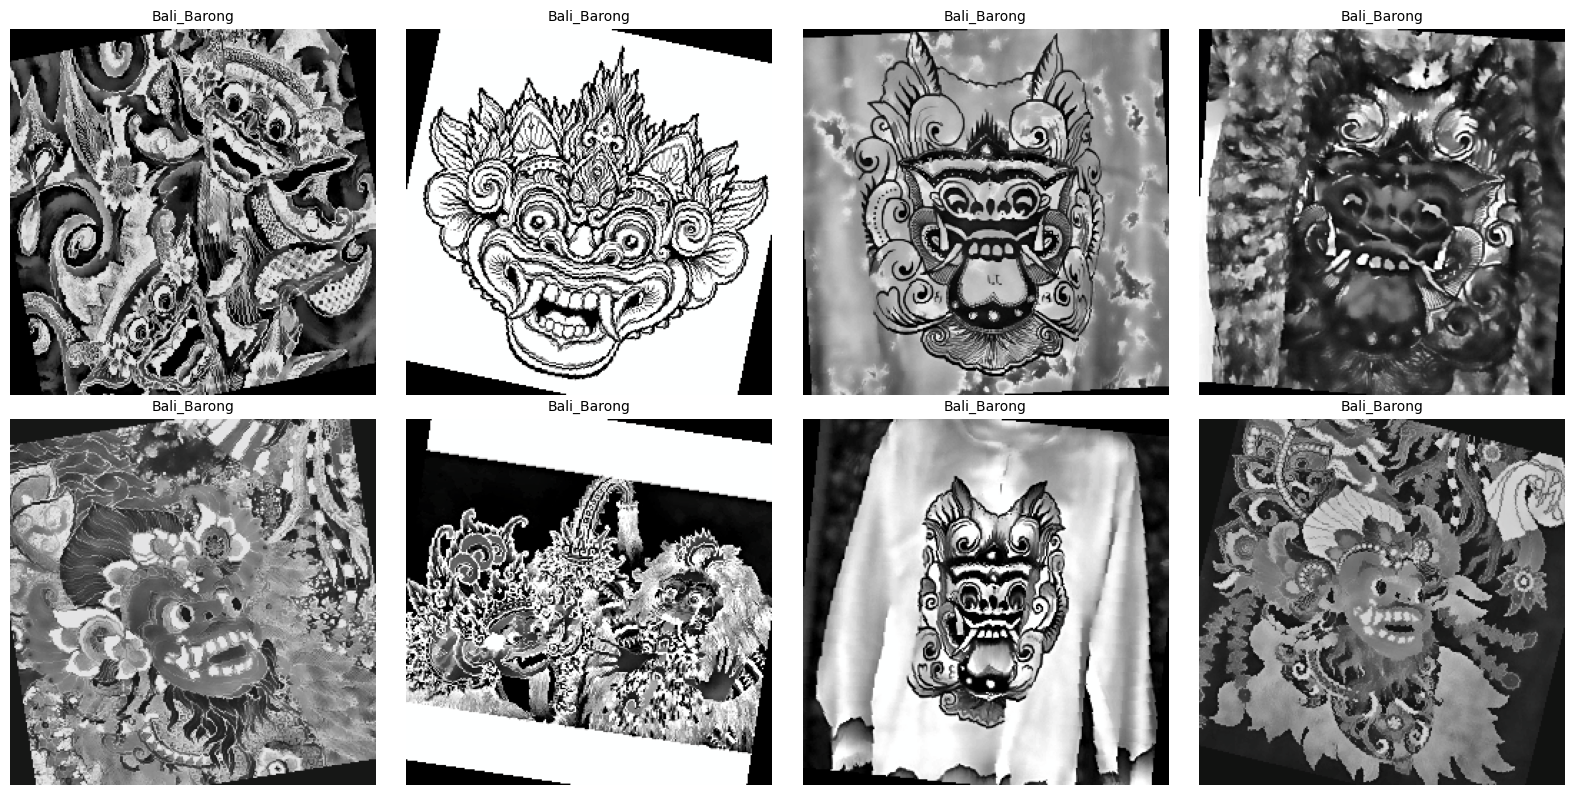

In [6]:
def visualize_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(dataset))):
        img, label = dataset[i]
        
        # Denormalize untuk visualisasi
        img_np = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        axes[i].imshow(img_np)
        axes[i].set_title(f"{dataset.classes[label]}", fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualisasi training samples
print("Training samples with preprocessing (Grayscale + CLAHE + Normalization):")
visualize_samples(train_dataset, num_samples=8)

# Verifikasi Preprocessing

Enhanced preprocessing pipeline visualization:


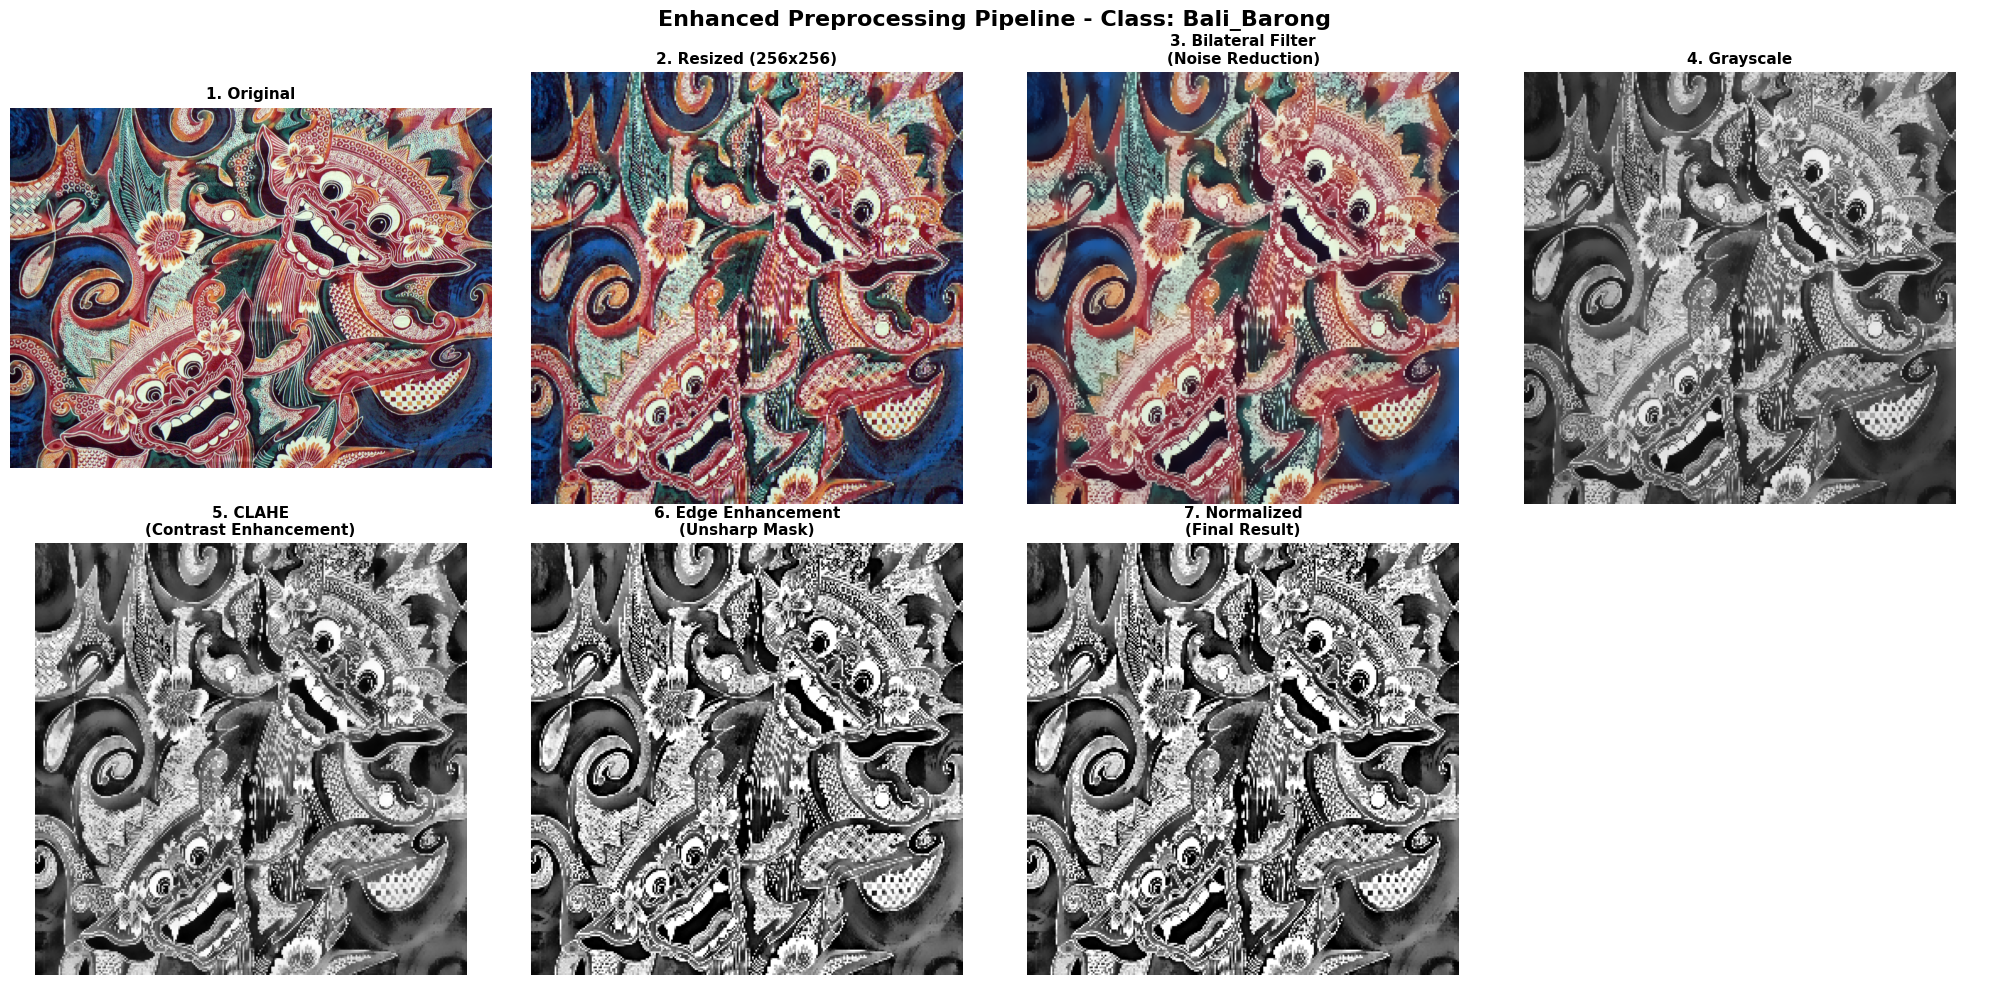

In [7]:
def show_preprocessing_comparison(dataset, idx=0):
    img_path, label = dataset.samples[idx]
    
    # Original image
    original = cv2.imread(img_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Step 1: Resized
    resized = cv2.resize(original, (IMG_SIZE, IMG_SIZE))
    
    # Step 2: Bilateral Filter (Noise Reduction)
    denoised = cv2.bilateralFilter(resized, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Step 3: Grayscale
    gray = cv2.cvtColor(denoised, cv2.COLOR_RGB2GRAY)
    
    # Step 4: CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_applied = clahe.apply(gray)
    
    # Step 5: Edge Enhancement (Unsharp Masking)
    gaussian = cv2.GaussianBlur(clahe_applied, (0, 0), 2.0)
    edge_enhanced = cv2.addWeighted(clahe_applied, 1.5, gaussian, -0.5, 0)
    
    # Step 6: Normalization
    normalized = cv2.normalize(edge_enhanced, None, 0, 255, cv2.NORM_MINMAX)
    
    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    images = [
        (original, '1. Original'),
        (resized, '2. Resized (256x256)'),
        (denoised, '3. Bilateral Filter\n(Noise Reduction)'),
        (cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB), '4. Grayscale'),
        (clahe_applied, '5. CLAHE\n(Contrast Enhancement)'),
        (edge_enhanced, '6. Edge Enhancement\n(Unsharp Mask)'),
        (normalized, '7. Normalized\n(Final Result)'),
    ]
    
    for i, (img, title) in enumerate(images):
        if len(img.shape) == 2:  # Grayscale
            axes[i].imshow(img, cmap='gray')
        else:  # RGB
            axes[i].imshow(img)
        axes[i].set_title(title, fontsize=11, fontweight='bold')
        axes[i].axis('off')
    
    # Hide last subplot
    axes[7].axis('off')
    
    plt.suptitle(f'Enhanced Preprocessing Pipeline - Class: {dataset.classes[label]}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Tampilkan preprocessing comparison
print("Enhanced preprocessing pipeline visualization:")
show_preprocessing_comparison(train_dataset, idx=0)

Before vs After preprocessing:


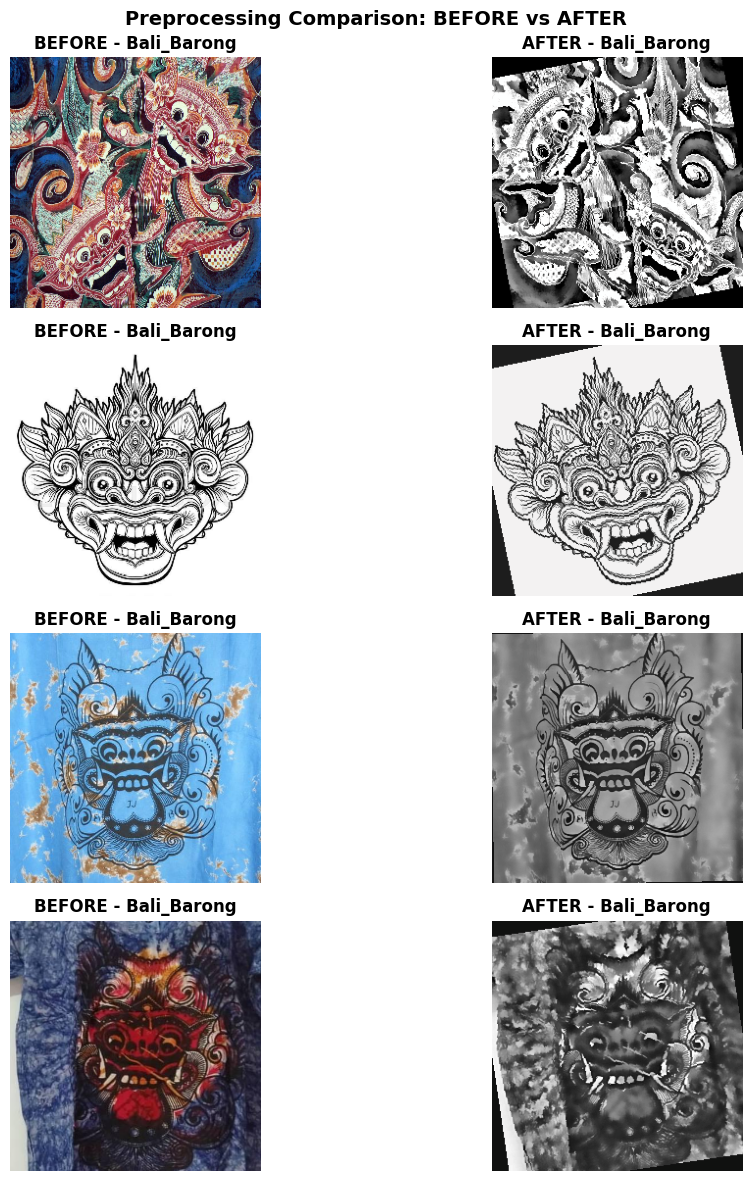

In [8]:
def compare_before_after(dataset, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, num_samples*3))
    
    for i in range(num_samples):
        img_path, label = dataset.samples[i]
        
        # Original
        original = cv2.imread(img_path)
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        original = cv2.resize(original, (IMG_SIZE, IMG_SIZE))
        
        # Processed (ambil dari dataset)
        processed, _ = dataset[i]
        processed_np = processed.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        processed_np = std * processed_np + mean
        processed_np = np.clip(processed_np, 0, 1)
        
        # Plot
        axes[i, 0].imshow(original)
        axes[i, 0].set_title(f'BEFORE - {dataset.classes[label]}', fontweight='bold')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(processed_np)
        axes[i, 1].set_title(f'AFTER - {dataset.classes[label]}', fontweight='bold')
        axes[i, 1].axis('off')
    
    plt.suptitle('Preprocessing Comparison: BEFORE vs AFTER', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Tampilkan perbandingan
print("Before vs After preprocessing:")
compare_before_after(train_dataset, num_samples=4)

## 1. GLCM (Gray Level Co-occurrence Matrix)

In [9]:
def extract_glcm_features(image):
    # Pastikan image dalam range 0-255 dan uint8
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    # Reduce levels untuk komputasi lebih cepat
    image = (image / 16).astype(np.uint8)
    
    # Hitung GLCM untuk 4 arah: 0°, 45°, 90°, 135°
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    glcm = graycomatrix(image, distances=distances, angles=angles, 
                        levels=16, symmetric=True, normed=True)
    
    # Ekstraksi properties
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    
    features = {}
    for prop in properties:
        values = graycoprops(glcm, prop).flatten()
        features[f'glcm_{prop}_mean'] = values.mean()
        features[f'glcm_{prop}_std'] = values.std()
    
    return features

# Test GLCM
print("Testing GLCM Feature Extraction...")
test_img_path, test_label = train_dataset.samples[0]
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (IMG_SIZE, IMG_SIZE))

glcm_features = extract_glcm_features(test_img)
print(f"GLCM Features extracted: {len(glcm_features)} features")
for key, value in list(glcm_features.items())[:5]:
    print(f"  {key}: {value:.4f}")

Testing GLCM Feature Extraction...
GLCM Features extracted: 12 features
  glcm_contrast_mean: 13.4185
  glcm_contrast_std: 1.3308
  glcm_dissimilarity_mean: 2.4741
  glcm_dissimilarity_std: 0.1647
  glcm_homogeneity_mean: 0.4248


## 2. LBP (Local Binary Pattern)

In [10]:
def extract_lbp_features(image, num_points=24, radius=3, n_bins=256):
    """
    Ekstraksi fitur LBP untuk analisis pola lokal batik
    
    Args:
        image: Grayscale image (numpy array)
        num_points: Jumlah sampling points
        radius: Radius circular sampling
        n_bins: Jumlah bins untuk histogram
    
    Returns:
        dict: Dictionary berisi fitur LBP
    """
    # Pastikan grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Hitung LBP
    lbp = local_binary_pattern(image, num_points, radius, method='uniform')
    
    # Hitung histogram
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    
    # Ekstraksi fitur statistik dari histogram
    features = {
        'lbp_mean': hist.mean(),
        'lbp_std': hist.std(),
        'lbp_skewness': skew(hist),
        'lbp_kurtosis': kurtosis(hist),
        'lbp_energy': np.sum(hist ** 2),
        'lbp_entropy': -np.sum(hist * np.log2(hist + 1e-7))
    }
    
    # Tambahkan histogram bins sebagai fitur (ambil 10 bins paling signifikan)
    top_bins = np.argsort(hist)[-10:]
    for i, bin_idx in enumerate(top_bins):
        features[f'lbp_bin_{i}'] = hist[bin_idx]
    
    return features, lbp

# Test LBP
print("Testing LBP Feature Extraction...")
lbp_features, lbp_image = extract_lbp_features(test_img)
print(f"LBP Features extracted: {len(lbp_features)} features")
for key, value in list(lbp_features.items())[:5]:
    print(f"  {key}: {value:.4f}")

Testing LBP Feature Extraction...
LBP Features extracted: 16 features
  lbp_mean: 0.0039
  lbp_std: 0.0363
  lbp_skewness: 14.6746
  lbp_kurtosis: 223.4156
  lbp_energy: 0.3422


## 3. Histogram Warna (HSV)

In [11]:
def extract_hsv_features(image, h_bins=32, s_bins=32, v_bins=32):
    # Konversi ke HSV jika belum
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Pisahkan channel
    h, s, v = cv2.split(hsv)
    
    features = {}
    
    # Histogram untuk setiap channel
    channels = [('h', h, h_bins, (0, 180)), 
                ('s', s, s_bins, (0, 256)), 
                ('v', v, v_bins, (0, 256))]
    
    for name, channel, bins, range_val in channels:
        hist = cv2.calcHist([channel], [0], None, [bins], range_val)
        hist = hist.flatten() / hist.sum()  # Normalize
        
        # Statistik dasar
        features[f'hsv_{name}_mean'] = channel.mean()
        features[f'hsv_{name}_std'] = channel.std()
        features[f'hsv_{name}_skewness'] = skew(channel.flatten())
        features[f'hsv_{name}_kurtosis'] = kurtosis(channel.flatten())
        
        # Fitur dari histogram
        features[f'hsv_{name}_hist_energy'] = np.sum(hist ** 2)
        features[f'hsv_{name}_hist_entropy'] = -np.sum(hist * np.log2(hist + 1e-7))
        
        # Dominant bins (3 teratas)
        top_3 = np.argsort(hist)[-3:]
        for i, bin_idx in enumerate(top_3):
            features[f'hsv_{name}_dominant_{i}'] = hist[bin_idx]
    
    return features

# Test HSV
print("Testing HSV Feature Extraction...")
test_img_color = cv2.imread(test_img_path)
test_img_color = cv2.resize(test_img_color, (IMG_SIZE, IMG_SIZE))

hsv_features = extract_hsv_features(test_img_color)
print(f"HSV Features extracted: {len(hsv_features)} features")
for key, value in list(hsv_features.items())[:5]:
    print(f"  {key}: {value:.4f}")

Testing HSV Feature Extraction...
HSV Features extracted: 27 features
  hsv_h_mean: 90.1162
  hsv_h_std: 64.8839
  hsv_h_skewness: -0.0494
  hsv_h_kurtosis: -1.5241
  hsv_h_hist_energy: 0.0557


## 4. Gabor Filter (Bonus - untuk tekstur terarah)

In [12]:
def create_gabor_kernels(num_orientations=8, num_scales=5):
    """Create Gabor filter bank"""
    kernels = []
    for theta in range(num_orientations):
        theta = theta / num_orientations * np.pi
        for sigma in range(1, num_scales + 1):
            lambd = sigma * 2
            gamma = 0.5
            kernel = cv2.getGaborKernel((21, 21), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)
            kernels.append(kernel)
    return kernels

def extract_gabor_features(image, kernels):
    """
    Ekstraksi fitur Gabor untuk analisis tekstur terarah batik
    
    Args:
        image: Grayscale image (numpy array)
        kernels: List of Gabor kernels
    
    Returns:
        dict: Dictionary berisi fitur Gabor
    """
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    features = {}
    
    for i, kernel in enumerate(kernels):
        # Apply Gabor filter
        filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
        
        # Ekstraksi statistik
        features[f'gabor_{i}_mean'] = filtered.mean()
        features[f'gabor_{i}_std'] = filtered.std()
        features[f'gabor_{i}_energy'] = np.sum(filtered ** 2) / filtered.size
    
    return features

# Create Gabor kernels
print("Creating Gabor filter bank...")
gabor_kernels = create_gabor_kernels(num_orientations=8, num_scales=5)
print(f"Created {len(gabor_kernels)} Gabor kernels")

# Test Gabor
print("\nTesting Gabor Feature Extraction...")
gabor_features = extract_gabor_features(test_img, gabor_kernels)
print(f"Gabor Features extracted: {len(gabor_features)} features")
for key, value in list(gabor_features.items())[:5]:
    print(f"  {key}: {value:.4f}")

Creating Gabor filter bank...
Created 40 Gabor kernels

Testing Gabor Feature Extraction...
Gabor Features extracted: 120 features
  gabor_0_mean: 44.7629
  gabor_0_std: 64.2498
  gabor_0_energy: 61.7212
  gabor_1_mean: 77.6177
  gabor_1_std: 92.4254


## 5. Kombinasi Semua Fitur

In [13]:
def extract_all_features(image_path, gabor_kernels):
    """
    Ekstraksi semua fitur: GLCM + LBP + HSV + Gabor
    
    Args:
        image_path: Path ke image
        gabor_kernels: Gabor filter bank
    
    Returns:
        dict: Dictionary berisi semua fitur
    """
    # Load image
    img_color = cv2.imread(image_path)
    img_color = cv2.resize(img_color, (IMG_SIZE, IMG_SIZE))
    
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    
    # Ekstraksi semua fitur
    all_features = {}
    
    # 1. GLCM
    glcm_feat = extract_glcm_features(img_gray)
    all_features.update(glcm_feat)
    
    # 2. LBP
    lbp_feat, _ = extract_lbp_features(img_gray)
    all_features.update(lbp_feat)
    
    # 3. HSV
    hsv_feat = extract_hsv_features(img_color)
    all_features.update(hsv_feat)
    
    # 4. Gabor
    gabor_feat = extract_gabor_features(img_gray, gabor_kernels)
    all_features.update(gabor_feat)
    
    return all_features

# Test ekstraksi lengkap
print("=" * 60)
print("EKSTRAKSI FITUR LENGKAP - SEMUA METODE")
print("=" * 60)

all_features = extract_all_features(test_img_path, gabor_kernels)

print(f"\nTotal features extracted: {len(all_features)}")
print("\nBreakdown:")
print(f"  - GLCM features: {len([k for k in all_features.keys() if 'glcm' in k])}")
print(f"  - LBP features: {len([k for k in all_features.keys() if 'lbp' in k])}")
print(f"  - HSV features: {len([k for k in all_features.keys() if 'hsv' in k])}")
print(f"  - Gabor features: {len([k for k in all_features.keys() if 'gabor' in k])}")

print("\nSample features:")
for i, (key, value) in enumerate(all_features.items()):
    if i < 10:
        print(f"  {key}: {value:.4f}")
print("  ...")

EKSTRAKSI FITUR LENGKAP - SEMUA METODE

Total features extracted: 175

Breakdown:
  - GLCM features: 12
  - LBP features: 16
  - HSV features: 27
  - Gabor features: 120

Sample features:
  glcm_contrast_mean: 13.4151
  glcm_contrast_std: 1.3295
  glcm_dissimilarity_mean: 2.4743
  glcm_dissimilarity_std: 0.1644
  glcm_homogeneity_mean: 0.4246
  glcm_homogeneity_std: 0.0239
  glcm_energy_mean: 0.1072
  glcm_energy_std: 0.0056
  glcm_correlation_mean: 0.6084
  glcm_correlation_std: 0.0388
  ...

Total features extracted: 175

Breakdown:
  - GLCM features: 12
  - LBP features: 16
  - HSV features: 27
  - Gabor features: 120

Sample features:
  glcm_contrast_mean: 13.4151
  glcm_contrast_std: 1.3295
  glcm_dissimilarity_mean: 2.4743
  glcm_dissimilarity_std: 0.1644
  glcm_homogeneity_mean: 0.4246
  glcm_homogeneity_std: 0.0239
  glcm_energy_mean: 0.1072
  glcm_energy_std: 0.0056
  glcm_correlation_mean: 0.6084
  glcm_correlation_std: 0.0388
  ...


## 6. Visualisasi Feature Extraction

Visualizing feature extraction process...


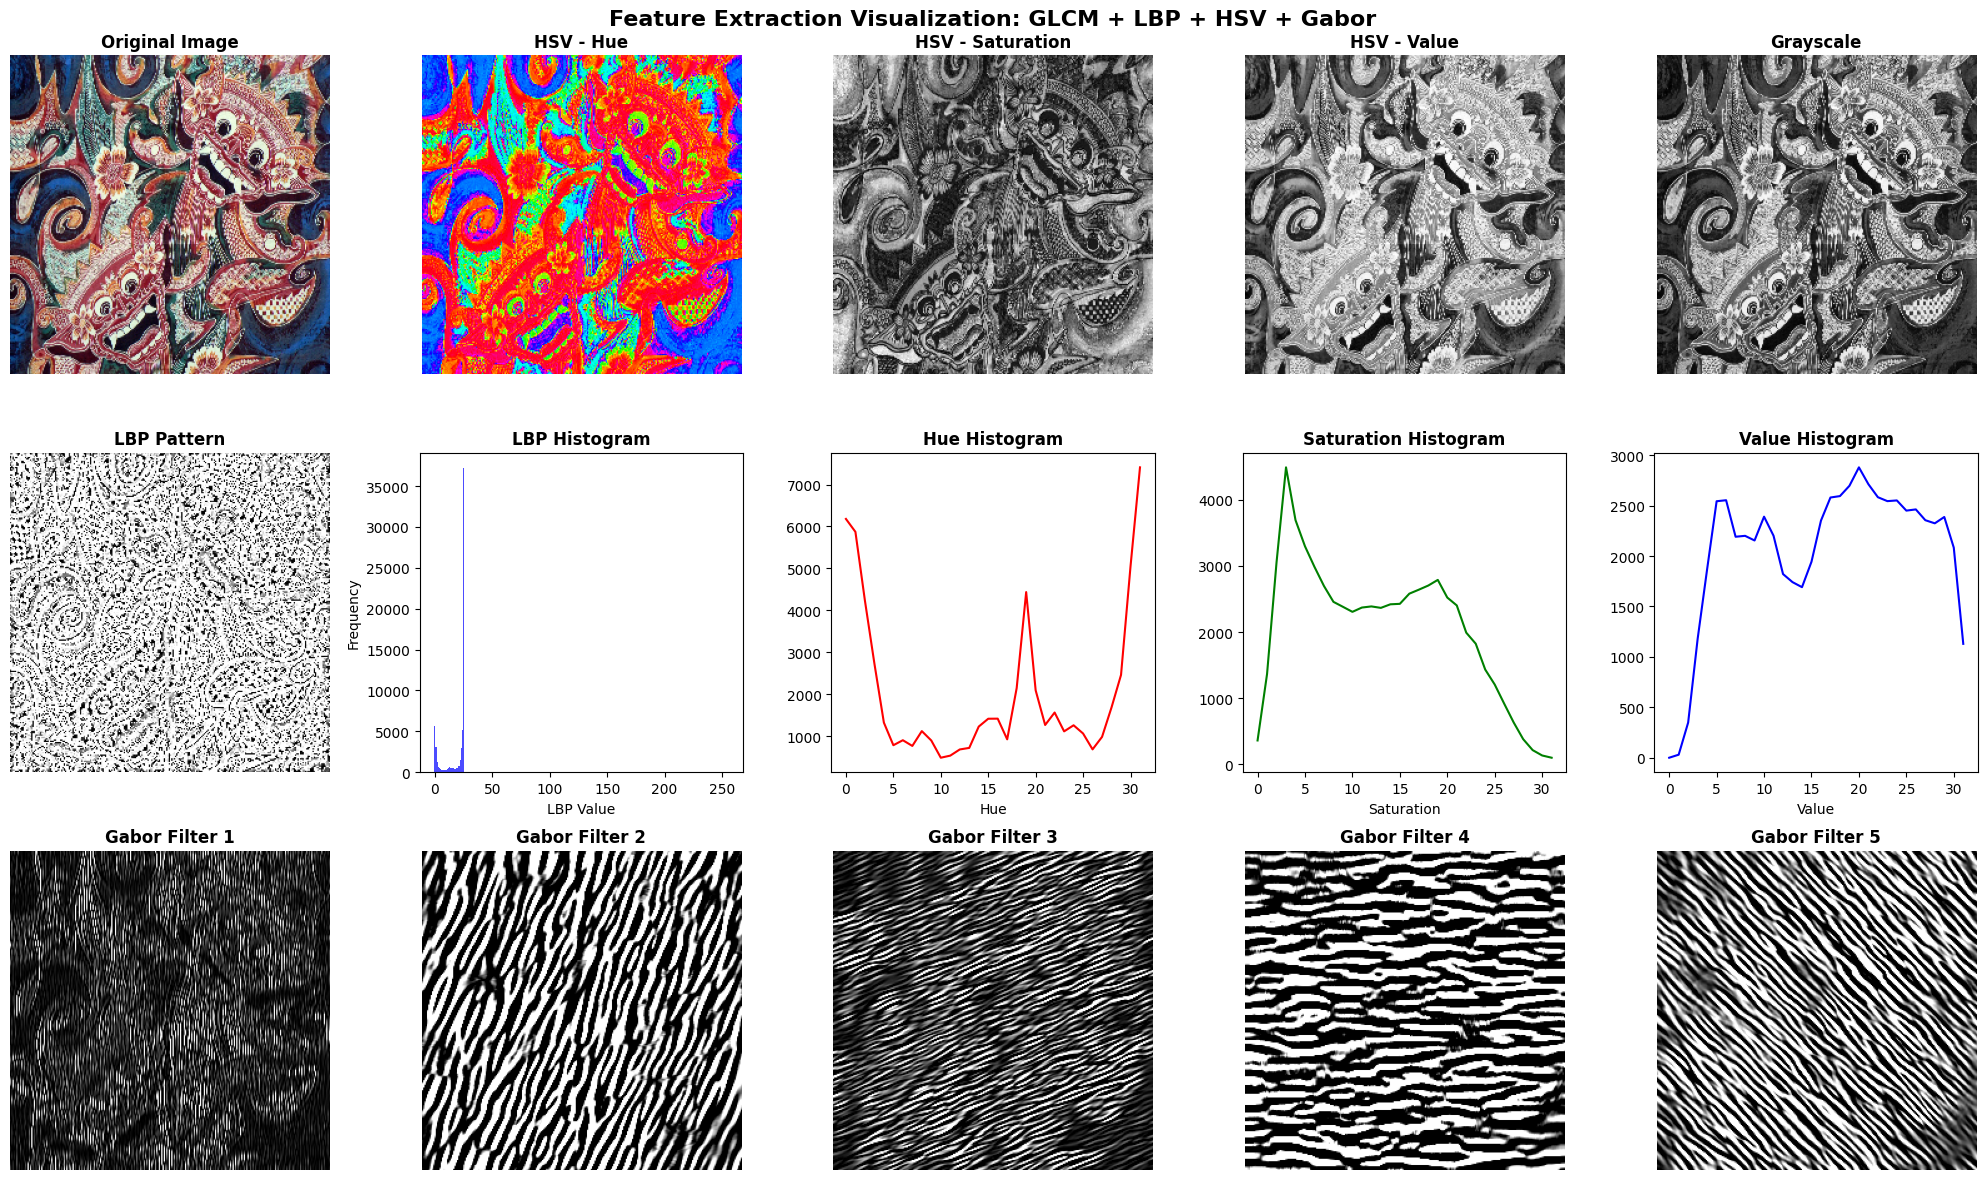

In [14]:
def visualize_feature_extraction(image_path, gabor_kernels):    
    # Load images
    img_color = cv2.imread(image_path)
    img_color = cv2.resize(img_color, (IMG_SIZE, IMG_SIZE))
    img_color_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    
    # HSV
    hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    # LBP
    _, lbp = extract_lbp_features(img_gray)
    
    # Gabor (visualisasi beberapa filter)
    gabor_results = []
    for kernel in gabor_kernels[::8]:  # Ambil setiap 8 kernel
        filtered = cv2.filter2D(img_gray, cv2.CV_8UC3, kernel)
        gabor_results.append(filtered)
    
    # Plot
    fig = plt.figure(figsize=(20, 12))
    
    # Row 1: Original and HSV channels
    ax1 = plt.subplot(3, 5, 1)
    ax1.imshow(img_color_rgb)
    ax1.set_title('Original Image', fontweight='bold')
    ax1.axis('off')
    
    ax2 = plt.subplot(3, 5, 2)
    ax2.imshow(h, cmap='hsv')
    ax2.set_title('HSV - Hue', fontweight='bold')
    ax2.axis('off')
    
    ax3 = plt.subplot(3, 5, 3)
    ax3.imshow(s, cmap='gray')
    ax3.set_title('HSV - Saturation', fontweight='bold')
    ax3.axis('off')
    
    ax4 = plt.subplot(3, 5, 4)
    ax4.imshow(v, cmap='gray')
    ax4.set_title('HSV - Value', fontweight='bold')
    ax4.axis('off')
    
    ax5 = plt.subplot(3, 5, 5)
    ax5.imshow(img_gray, cmap='gray')
    ax5.set_title('Grayscale', fontweight='bold')
    ax5.axis('off')
    
    # Row 2: LBP
    ax6 = plt.subplot(3, 5, 6)
    ax6.imshow(lbp, cmap='gray')
    ax6.set_title('LBP Pattern', fontweight='bold')
    ax6.axis('off')
    
    # LBP Histogram
    ax7 = plt.subplot(3, 5, 7)
    hist, bins = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
    ax7.bar(bins[:-1], hist, width=1, color='blue', alpha=0.7)
    ax7.set_title('LBP Histogram', fontweight='bold')
    ax7.set_xlabel('LBP Value')
    ax7.set_ylabel('Frequency')
    
    # HSV Histograms
    ax8 = plt.subplot(3, 5, 8)
    hist_h = cv2.calcHist([h], [0], None, [32], [0, 180])
    ax8.plot(hist_h, color='red')
    ax8.set_title('Hue Histogram', fontweight='bold')
    ax8.set_xlabel('Hue')
    
    ax9 = plt.subplot(3, 5, 9)
    hist_s = cv2.calcHist([s], [0], None, [32], [0, 256])
    ax9.plot(hist_s, color='green')
    ax9.set_title('Saturation Histogram', fontweight='bold')
    ax9.set_xlabel('Saturation')
    
    ax10 = plt.subplot(3, 5, 10)
    hist_v = cv2.calcHist([v], [0], None, [32], [0, 256])
    ax10.plot(hist_v, color='blue')
    ax10.set_title('Value Histogram', fontweight='bold')
    ax10.set_xlabel('Value')
    
    # Row 3: Gabor filters
    for i, gabor_img in enumerate(gabor_results[:5]):
        ax = plt.subplot(3, 5, 11 + i)
        ax.imshow(gabor_img, cmap='gray')
        ax.set_title(f'Gabor Filter {i+1}', fontweight='bold')
        ax.axis('off')
    
    plt.suptitle('Feature Extraction Visualization: GLCM + LBP + HSV + Gabor', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualisasi
print("Visualizing feature extraction process...")
visualize_feature_extraction(test_img_path, gabor_kernels)

# Feature Extraction - Ekstraksi Fitur Batik

In [15]:
def extract_dataset_features(dataset, gabor_kernels, max_samples=None):
    features_list = []
    labels_list = []
    
    num_samples = len(dataset) if max_samples is None else min(max_samples, len(dataset))
    
    print(f"Extracting features from {num_samples} samples...")
    
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"  Progress: {i}/{num_samples}")
        
        img_path, label = dataset.samples[i]
        
        # Ekstraksi fitur
        features = extract_all_features(img_path, gabor_kernels)
        
        features_list.append(features)
        labels_list.append(label)
    
    # Convert to DataFrame
    df_features = pd.DataFrame(features_list)
    df_features['label'] = labels_list
    df_features['class_name'] = [dataset.classes[l] for l in labels_list]
    
    print(f"\nFeature extraction completed!")
    print(f"  Total samples: {len(df_features)}")
    print(f"  Total features: {len(df_features.columns) - 2}")  # -2 untuk label dan class_name
    
    return df_features

# Contoh: Ekstraksi fitur dari subset kecil
print("Example: Extracting features from 50 training samples...")
df_features_sample = extract_dataset_features(train_dataset, gabor_kernels, max_samples=50)

print("\nFeature DataFrame preview:")
print(df_features_sample.head())

print("\nFeature statistics:")
print(df_features_sample.describe())

Example: Extracting features from 50 training samples...
Extracting features from 50 samples...
  Progress: 0/50

Feature extraction completed!
  Total samples: 50
  Total features: 175

Feature DataFrame preview:
   glcm_contrast_mean  glcm_contrast_std  glcm_dissimilarity_mean  \
0           13.415150           1.329455                 2.474311   
1           24.346240           3.141044                 2.472721   
2            3.908794           0.647979                 1.093806   
3            1.824894           0.404807                 0.822341   
4            6.151740           0.462837                 1.785375   

   glcm_dissimilarity_std  glcm_homogeneity_mean  glcm_homogeneity_std  \
0                0.164377               0.424644              0.023935   
1                0.237527               0.678247              0.017719   
2                0.114858               0.663959              0.022790   
3                0.108769               0.673227              0.031416   
4

In [16]:
# VGG16 Model - Training & Evaluation

In [17]:
# Training configuration
NUM_CLASSES = len(train_dataset.classes)
LEARNING_RATE = 0.0001
NUM_EPOCHS = 50
PATIENCE = 10  # Early stopping patience

print(f"Number of classes: {NUM_CLASSES}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Max epochs: {NUM_EPOCHS}")
print(f"Device: {device}")

Number of classes: 111
Learning rate: 0.0001
Max epochs: 50
Device: cuda


In [18]:
class VGG16_FromScratch(nn.Module):
    def __init__(self, num_classes=1000, input_channels=3, dropout=0.5):
        super(VGG16_FromScratch, self).__init__()
        
        # VGG16 Feature Extractor
        # Block 1
        self.conv1_1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 4
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 5
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Classifier
        # Input size: 256x256 -> after 5 pooling layers: 8x8
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 8 * 8, 4096)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(p=dropout)
        
        self.fc2 = nn.Linear(4096, 4096)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(p=dropout)
        
        self.fc3 = nn.Linear(4096, num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        
        # Block 2
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        
        # Block 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)
        
        # Block 4
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool4(x)
        
        # Block 5
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool5(x)
        
        # Classifier
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x
    
    def _initialize_weights(self):
        """Initialize weights using He initialization for ReLU"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

# Create model
model = VGG16_FromScratch(num_classes=NUM_CLASSES, input_channels=3, dropout=0.5)
model = model.to(device)

print("\n" + "="*70)
print("VGG16 FROM SCRATCH - CUSTOM ARCHITECTURE FOR BATIK")
print("="*70)
print(f"Input: 3-channel RGB (256x256)")
print(f"Output: {NUM_CLASSES} classes")
print(f"Architecture: 13 Conv layers + 3 FC layers")
print(f"Preprocessing: Grayscale + Bilateral Filter + CLAHE + Edge Enhancement")
print("="*70)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size (approx): {total_params * 4 / (1024**2):.2f} MB")
print("="*70)

# Test forward pass
with torch.no_grad():
    test_input = torch.randn(1, 3, 256, 256).to(device)
    test_output = model(test_input)
    print(f"\nTest forward pass:")
    print(f"  Input shape: {test_input.shape}")
    print(f"  Output shape: {test_output.shape}")
    print(f"  ✓ Model ready for training!")
print("="*70)




VGG16 FROM SCRATCH - CUSTOM ARCHITECTURE FOR BATIK
Input: 3-channel RGB (256x256)
Output: 111 classes
Architecture: 13 Conv layers + 3 FC layers
Preprocessing: Grayscale + Bilateral Filter + CLAHE + Edge Enhancement

Total parameters: 166,172,591
Trainable parameters: 166,172,591
Model size (approx): 633.90 MB

Test forward pass:
  Input shape: torch.Size([1, 3, 256, 256])
  Output shape: torch.Size([1, 111])
  ✓ Model ready for training!


# Loss Function

In [19]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - Adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print("Loss function: CrossEntropyLoss")
print("Optimizer: Adam")
print("Scheduler: ReduceLROnPlateau")

Loss function: CrossEntropyLoss
Optimizer: Adam
Scheduler: ReduceLROnPlateau


d:\MOBILE\Model\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 3. Training & Validation Functions

In [20]:
from tqdm.notebook import tqdm

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar untuk training
    pbar = tqdm(train_loader, desc='Training', leave=False)
    
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar untuk validation
    pbar = tqdm(val_loader, desc='Validation', leave=False)
    
    with torch.no_grad():
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

print("Training and validation functions defined with progress bars!")

Training and validation functions defined with progress bars!


## 4. Training Loop with Early Stopping

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'vgg16_batik_best.pth'

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

import time
from tqdm.notebook import tqdm

start_time = time.time()

# Progress bar untuk epochs
epoch_pbar = tqdm(range(NUM_EPOCHS), desc='Overall Progress')

for epoch in epoch_pbar:
    epoch_pbar.set_description(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Update epoch progress bar
    epoch_pbar.set_postfix({
        'Train Loss': f'{train_loss:.4f}',
        'Train Acc': f'{train_acc:.2f}%',
        'Val Loss': f'{val_loss:.4f}',
        'Val Acc': f'{val_acc:.2f}%'
    })
    
    # Print epoch summary
    print(f'\n[Epoch {epoch+1}/{NUM_EPOCHS}] '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%', end='')
    
    # Early stopping & save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f' ✓ BEST', end='')
    else:
        patience_counter += 1
        print(f' [{patience_counter}/{PATIENCE}]', end='')
        
        if patience_counter >= PATIENCE:
            print(f'\n\n⚠ Early stopping triggered after {epoch+1} epochs')
            break
    
    print()  # Newline

elapsed_time = time.time() - start_time
print("\n" + "="*60)
print("TRAINING COMPLETED!")
print("="*60)
print(f"Total training time: {elapsed_time/60:.2f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best model saved to: {best_model_path}")
print("="*60)


STARTING TRAINING


Overall Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/3176 [00:00<?, ?it/s]

## 5. Plot Training History

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print("\n" + "="*60)
    print("FINAL TRAINING METRICS")
    print("="*60)
    print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"Final Val Accuracy: {history['val_acc'][-1]:.2f}%")
    print(f"Best Val Loss: {min(history['val_loss']):.4f}")
    print(f"Best Val Accuracy: {max(history['val_acc']):.2f}%")
    print("="*60)

# Plot
plot_training_history(history)

## 6. Evaluate on Test Set

In [ ]:
# Load best model
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from: {best_model_path}")

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("="*60)

## 7. Detailed Evaluation - Confusion Matrix & Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_detailed(model, test_loader, device, class_names):
    """Detailed evaluation with confusion matrix"""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.numpy())
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(20, 18))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Batik Classification', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\n" + "="*80)
    print("CLASSIFICATION REPORT")
    print("="*80)
    print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))
    print("="*80)
    
    return cm, all_preds, all_targets

# Evaluate
cm, predictions, targets = evaluate_detailed(model, test_loader, device, test_dataset.classes)

## 8. Save Final Model & Metadata

In [ ]:
# Save complete model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': len(history['train_loss']),
    'best_val_loss': best_val_loss,
    'class_names': test_dataset.classes,
    'num_classes': NUM_CLASSES,
    'history': history
}, 'vgg16_batik_complete_final.pth')

# Save just weights
torch.save(model.state_dict(), 'vgg16_batik_weights_final.pth')

# Save class names
with open('labels.txt', 'w') as f:
    for class_name in test_dataset.classes:
        f.write(f"{class_name}\n")

# Save training config
config = {
    'model': 'VGG16',
    'num_classes': NUM_CLASSES,
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'num_epochs': len(history['train_loss']),
    'best_val_loss': float(best_val_loss),
    'best_val_acc': float(max(history['val_acc'])),
    'test_loss': float(test_loss),
    'test_acc': float(test_acc),
    'preprocessing': 'Bilateral Filter + CLAHE + Edge Enhancement + Normalization',
    'augmentation': 'RandomHorizontalFlip + RandomRotation + ColorJitter'
}

with open('model_config_final.json', 'w') as f:
    json.dump(config, f, indent=4)

print("\n" + "="*60)
print("MODEL SAVED!")
print("="*60)
print(f"✓ Complete model: vgg16_batik_complete_final.pth")
print(f"✓ Weights only: vgg16_batik_weights_final.pth")
print(f"✓ Class labels: labels.txt")
print(f"✓ Configuration: model_config_final.json")
print("="*60)

## 9. Prediction on New Images (Demo)

In [ ]:
# Save complete model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': len(history['train_loss']),
    'best_val_loss': best_val_loss,
    'class_names': test_dataset.classes,
    'num_classes': NUM_CLASSES,
    'history': history
}, 'vgg16_batik_complete_final.pth')

# Save just weights
torch.save(model.state_dict(), 'vgg16_batik_weights_final.pth')

# Save class names
with open('labels.txt', 'w') as f:
    for class_name in test_dataset.classes:
        f.write(f"{class_name}\n")

# Save training config
config = {
    'model': 'VGG16',
    'num_classes': NUM_CLASSES,
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'num_epochs': len(history['train_loss']),
    'best_val_loss': float(best_val_loss),
    'best_val_acc': float(max(history['val_acc'])),
    'test_loss': float(test_loss),
    'test_acc': float(test_acc),
    'preprocessing': 'Bilateral Filter + CLAHE + Edge Enhancement + Normalization',
    'augmentation': 'RandomHorizontalFlip + RandomRotation + ColorJitter'
}

with open('model_config_final.json', 'w') as f:
    json.dump(config, f, indent=4)

print("\n" + "="*60)
print("MODEL SAVED!")
print("="*60)
print(f"✓ Complete model: vgg16_batik_complete_final.pth")
print(f"✓ Weights only: vgg16_batik_weights_final.pth")
print(f"✓ Class labels: labels.txt")
print(f"✓ Configuration: model_config_final.json")
print("="*60)